In [29]:
import pandas as pd 
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from matplotlib import pyplot as plt 

# Estimate N/A-angles with non-NN methods

In [2]:
train_df = pd.read_json('../../data/train.json', dtype='float32')
test_df = pd.read_json('../../data/test.json', dtype='float32')

#### Check loading ok

In [3]:
train_df.head(2)

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0.0
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0.0


In [4]:
ang_test = train_df[train_df.inc_angle == 'na']
ang_test = ang_test[['band_1', 'band_2']]

In [5]:
ang_test_X = []
for idx, row in ang_test.iterrows():
    band_1 = np.array(row['band_1'])
    band_2 = np.array(row['band_2'])
    ang_test_X.append(band_2 - band_1)
    
ang_test_X = np.array(ang_test_X)
ang_test_X.shape

(133, 5625)

#### Train only on non-iceberg data 

In [6]:
ang_train = train_df[train_df.is_iceberg == 0.0]
ang_train = ang_train[ang_train.inc_angle != 'na']

In [7]:
ang_train_X = []
for idx, row in ang_train.iterrows():
    band_1 = np.array(row['band_1'])
    band_2 = np.array(row['band_2'])
    ang_train_X.append(band_2 - band_1)
    
ang_train_X = np.array(ang_train_X)
ang_train_X.shape

(718, 5625)

In [8]:
ang_train_Y = np.array(ang_train['inc_angle'])
ang_train_Y.shape

(718,)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(ang_train_X, ang_train_Y, test_size=0.33, random_state=42)

# LASSO 

In [13]:
lasso_mdl = LassoCV(max_iter = 10, random_state=42)
lasso_mdl_fit = lasso_mdl.fit(X_train, y_train)

c:\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [14]:
y_pred = lasso_mdl_fit.predict(X_test)

In [19]:
mse = mean_squared_error(y_test, y_pred)
print(mse)

16.2272438141


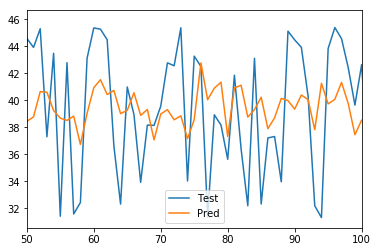

In [28]:
fig = plt.figure()
plt.plot(y_test)
plt.plot(y_pred)
plt.legend(['Test', 'Pred'])
plt.xlim([50, 100])
plt.show()

#### Not a very linear problem and therefore not very good result with a linear model...

# Random Forest Regression

In [36]:
rf_model = RandomForestRegressor(max_depth=10, random_state=42)
rf_model_fit = rf_model.fit(X_train, y_train)
y_pred_rf = rf_model_fit.predict(X_test)

In [37]:
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(mse_rf)

18.6528840568


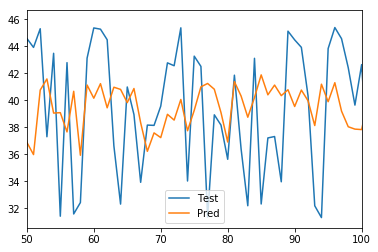

In [38]:
fig = plt.figure()
plt.plot(y_test)
plt.plot(y_pred_rf)
plt.legend(['Test', 'Pred'])
plt.xlim([50, 100])
plt.show()

# Feed-Forward Neural Network

In [56]:
from keras.layers import Input, Dense
from keras.models import Model

input1 = Input(shape=(481, 5625), name='Input')
x1 = Dense(units=10, activation='relu', name='FC-1')(input1)
x1 = Dense(units=10, activation='relu', name='FC-2')(x1)
predicts = Dense(units=1, activation='relu', name='Output')(x1)

model = Model(inputs=input1, outputs=predicts)
model.compile(optimizer='sgd', loss='mse', metrics=['accuracy'])
model.summary()

SyntaxError: invalid syntax (<ipython-input-56-a21d98dfe4ea>, line 4)

In [55]:
mdlhist = model.fit(x = X_train, y = y_train, batch_size=32, epochs=15)

ValueError: Error when checking model input: expected Input to have 4 dimensions, but got array with shape (481, 5625)

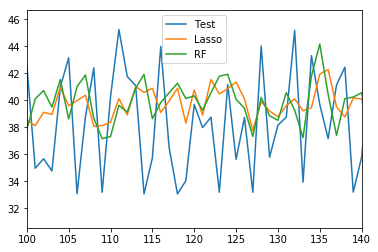

In [43]:
fig = plt.figure()
plt.plot(y_test)
plt.plot(y_pred)
plt.plot(y_pred_rf)
plt.legend(['Test', 'Lasso', 'RF'])
plt.xlim([100, 140])
plt.show()